### Modelling local authority -> classification

* A key question when handling geographic data is whether to split by location.
* For this task we opted not to split by location as we needed to maintain even sampling of the local authority for our model.
* KNN is naturally suited for the role. 


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KNeighborsClassifier

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold

from flood_tool.geo import get_gps_lat_long_from_easting_northing
from utils.utils import init_logging
init_logging()

%load_ext autoreload
%autoreload 2

rds = 42

In [2]:
df = pd.read_csv('../flood_tool/resources/postcodes_labelled.csv')

In [3]:
lat, lon = get_gps_lat_long_from_easting_northing(north=df.northing, east=df.easting, rads=False)

df['lat'] = lat
df['lon'] = lon

In [4]:
le = LabelEncoder()
df['encoded_target'] = le.fit_transform(df.localAuthority)

Text(0.5, 1.0, 'OS easting northing projection')

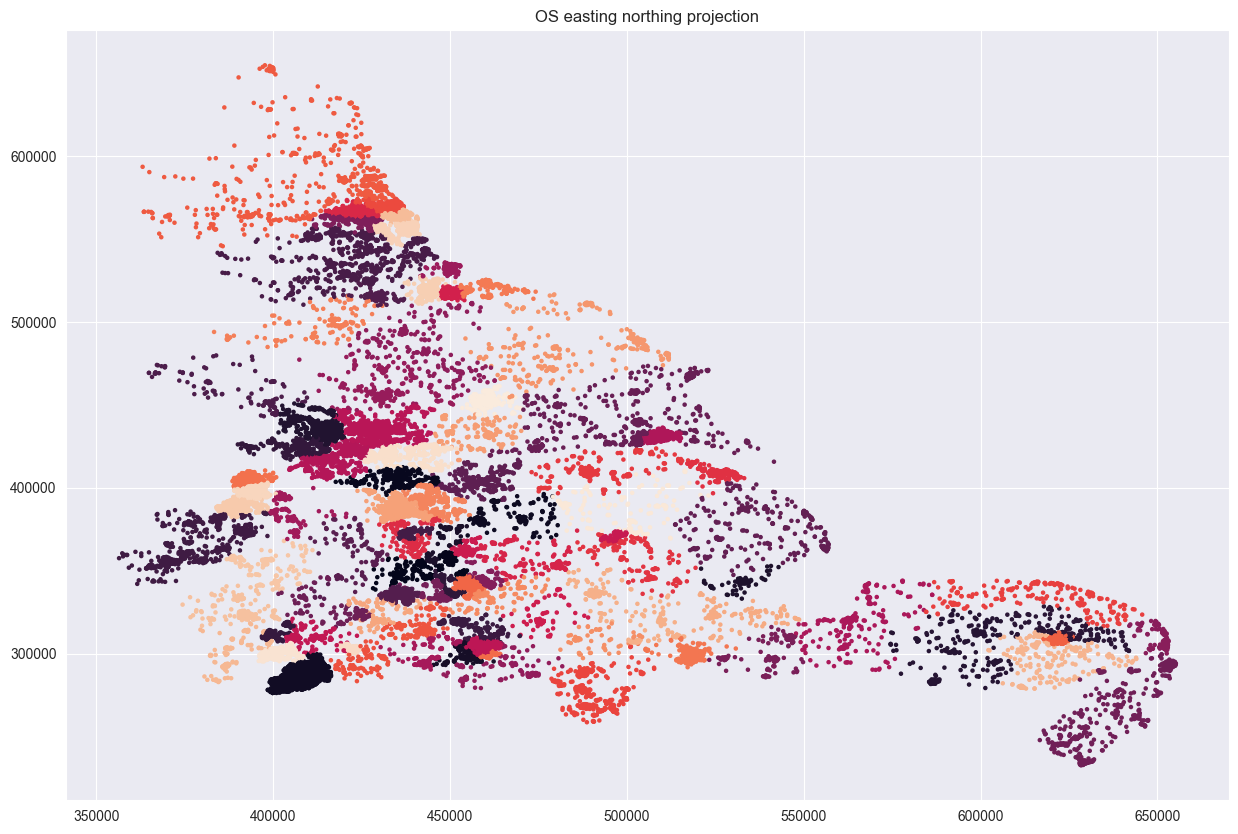

In [5]:
fig, ax = plt.subplots(1,1,figsize=(15, 10))
ax.scatter(df.easting, df.northing, s=5, c=df.encoded_target)
ax.set_title('OS easting northing projection')

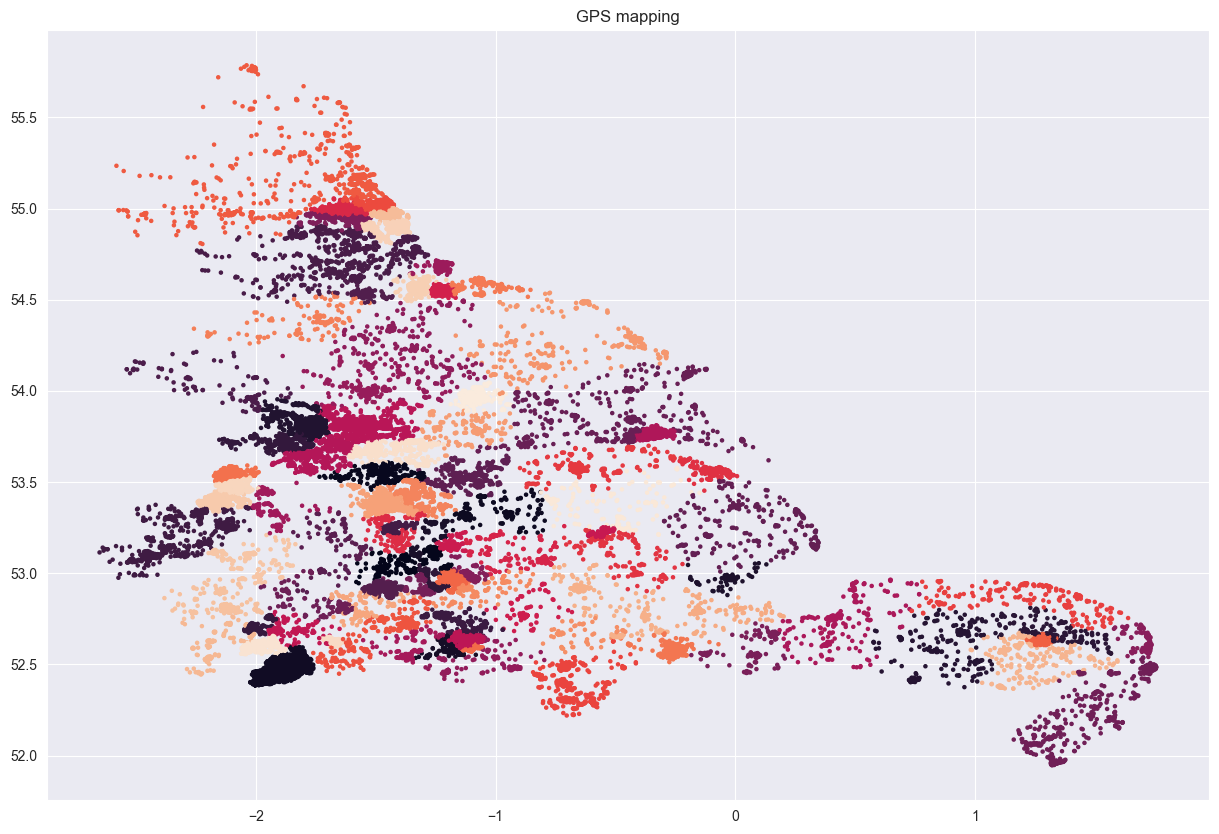

In [6]:
fig, ax = plt.subplots(1,1,figsize=(15, 10))
ax.scatter(df.lon, df.lat, s=5, c=df.encoded_target);
ax.set_title('GPS mapping');

<Axes: >

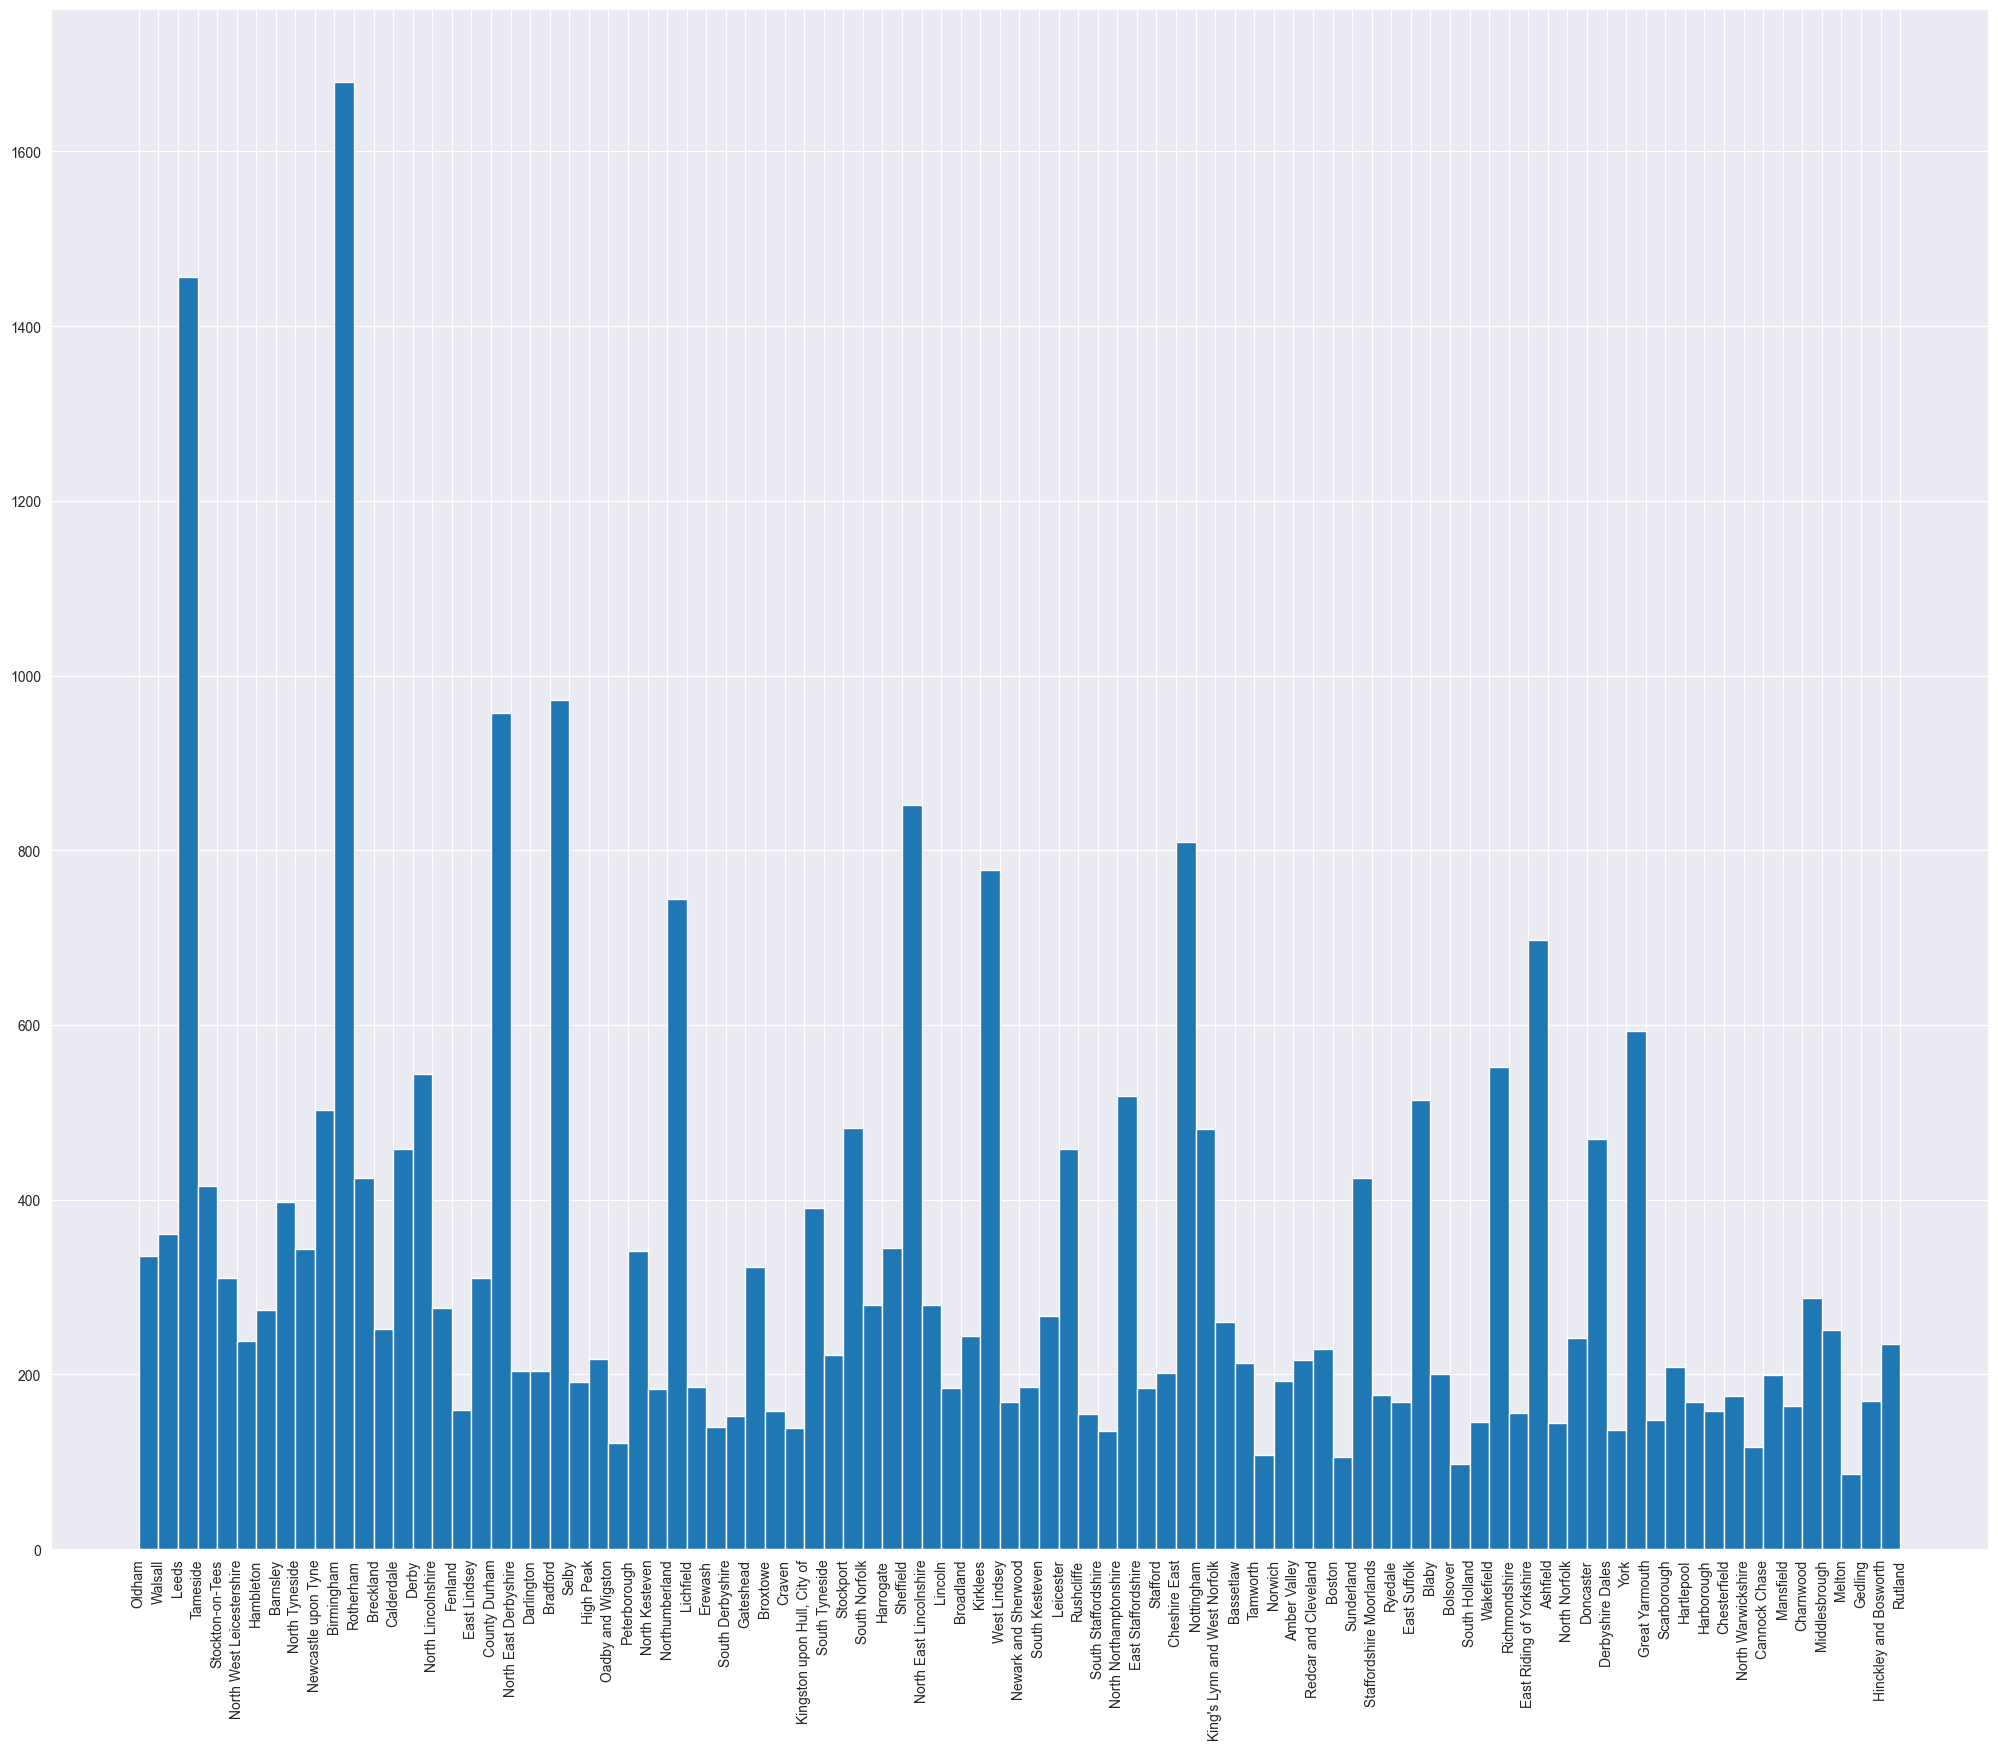

In [7]:
df.localAuthority.hist(xrot=90, figsize=(25, 20), bins=90)

In [8]:
df.isna().sum()

postcode                  0
easting                   0
northing                  0
soilType                  0
elevation                 0
localAuthority            0
riskLabel                 0
medianPrice            3235
historicallyFlooded       0
lat                       0
lon                       0
encoded_target            0
dtype: int64

In [9]:
df.duplicated().sum()

0

In [10]:
df.set_index('postcode', inplace=True)
X = df[['easting', 'northing', 'lat', 'lon']]
y = df['localAuthority']

In [11]:
le = LabelEncoder()
y = le.fit_transform(y)

In [12]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=rds, stratify=y)

In [13]:
X_train_os = X_train[['easting', 'northing']]
X_train_gps = X_train[['lat', 'lon']]

X_test_os = X_test[['easting', 'northing']]
X_test_gps = X_test[['lat', 'lon']]

## Dummy

In [14]:
from sklearn.dummy import DummyClassifier

dummy_model = DummyClassifier(strategy='stratified', random_state=rds)
skfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=rds)
dummy_cv_score = cross_val_score(dummy_model, X_train_os, y_train, cv=skfold, scoring='f1_macro', n_jobs=-1)

In [15]:
dummy_cv_score.mean()

0.0101738467273015

## KNN

In [16]:
knn_model = KNeighborsClassifier()
skfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=rds)
knn_cv_score = cross_val_score(knn_model, X_train_os, y_train, cv=skfold, scoring='f1_macro', n_jobs=-1)

In [17]:
knn_cv_score.mean()

0.9716218436610029

## Random Forest

In [18]:
from sklearn.ensemble import RandomForestClassifier

In [19]:
rf_model = RandomForestClassifier()
skfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=rds)
rf_cv_score = cross_val_score(rf_model, X_train_os, y_train, cv=skfold, scoring='f1_macro', n_jobs=-1)

In [20]:
rf_cv_score.mean()

0.9735158226995206

## Best model evaluate on holdout set

In [21]:
from sklearn.metrics import f1_score
final_model = knn_model
final_model.fit(X_train_os, y_train)
y_hat = final_model.predict(X_test_os)

final_f1 = f1_score(y_test, y_hat, average='macro')
final_f1

0.9765040554098745

## Using Haversine with lat/lon

In [22]:
X_train_gps

,lat,lon
postcode,,
DH3 9EU,54.853896,-1.574005
NE28 6RB,54.990351,-1.534006
HX1 3SS,53.715077,-1.883430
M34 7FZ,53.443280,-2.106175
LS15 7TJ,53.807401,-1.465443
...,...,...
LE11 9TB,52.768584,-1.204954
DE21 6QF,52.921962,-1.441097
NR18 0ER,52.581829,1.135446


## Haversine

In [23]:
knn_hav_model = KNeighborsClassifier(metric='haversine')
skfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=rds)
knn_hav_score = cross_val_score(knn_hav_model, X_train_gps, y_train, cv=skfold, scoring='f1_macro', n_jobs=-1)

In [24]:
knn_hav_score

array([0.97031544, 0.96750986, 0.96326216, 0.96806376, 0.9626857 ])

## Hyperparameter tuning

In [25]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV


pipeline = Pipeline(
    steps=[
        ('scaler', MinMaxScaler()),
        ('model', KNeighborsClassifier())
    ]
)



In [26]:
pipeline.get_params()

{'memory': None,
 'steps': [('scaler', MinMaxScaler()), ('model', KNeighborsClassifier())],
 'verbose': False,
 'scaler': MinMaxScaler(),
 'model': KNeighborsClassifier(),
 'scaler__clip': False,
 'scaler__copy': True,
 'scaler__feature_range': (0, 1),
 'model__algorithm': 'auto',
 'model__leaf_size': 30,
 'model__metric': 'minkowski',
 'model__metric_params': None,
 'model__n_jobs': None,
 'model__n_neighbors': 5,
 'model__p': 2,
 'model__weights': 'uniform'}

In [27]:
from sklearn.preprocessing import StandardScaler
import scipy.stats as stats

param_distro = {
    'scaler': [MinMaxScaler(), StandardScaler(), None],
    # 'model__metric': ['haversine'],
    'model__n_neighbors': stats.randint(2, 10),
    # 'model__p': stats.randint(1, 10),
    'model__weights': ['uniform', 'distance'],
    'model__algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
    # 'model__algorithm': ['auto', 'ball_tree', 'brute'],
}


In [28]:
skfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=rds)
rand_cv = RandomizedSearchCV(estimator=pipeline, param_distributions=param_distro, n_iter=5, n_jobs=-1, verbose=2, scoring='f1_macro', random_state=rds)

In [29]:
rand_cv.fit(X_train_gps, y_train)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


RandomizedSearchCV(estimator=Pipeline(steps=[('scaler', MinMaxScaler()),
                                             ('model',
                                              KNeighborsClassifier())]),
                   n_iter=5, n_jobs=-1,
                   param_distributions={'model__algorithm': ['auto',
                                                             'ball_tree',
                                                             'kd_tree',
                                                             'brute'],
                                        'model__n_neighbors': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x28423ef90>,
                                        'model__weights': ['uniform',
                                                           'distance'],
                                        'scaler': [MinMaxScaler(),
                                                   StandardScaler(), None]},
                   random_state=42, scoring='f1_macro', verbose=2)

In [30]:
rand_cv.best_score_

0.9785818618598165

In [31]:
rand_cv.best_params_

{'model__algorithm': 'kd_tree',
 'model__n_neighbors': 4,
 'model__weights': 'distance',
 'scaler': MinMaxScaler()}

## Test on unseen data

In [32]:
df_unseen = pd.read_csv('../flood_tool/resources/postcodes_unlabelled.csv')

In [33]:
df_unseen

,postcode,easting,northing,soilType,elevation
0,M34 7QL,393470,394371,Unsurveyed/Urban,110
1,OL4 3NQ,395420,405669,Unsurveyed/Urban,210
2,B36 8TE,411900,289400,Unsurveyed/Urban,90
3,NE16 3AT,420400,562300,Unsurveyed/Urban,10
4,WS10 8DE,397726,296656,Unsurveyed/Urban,140
...,...,...,...,...,...
9995,NN9 7TY,488200,264700,Cambisols,80
9996,HU6 7YG,508055,434044,Unsurveyed/Urban,0
9997,LS12 1DY,428431,432867,Unsurveyed/Urban,40
9998,DN4 6TZ,462498,401208,Arenosols,10


In [34]:
X_new = df_unseen[['easting', 'northing']]

In [35]:
y_hat_new = final_model.predict(X_new)
predictions = le.inverse_transform(y_hat_new)

In [36]:
predictions

array(['Tameside', 'Oldham', 'Birmingham', ..., 'Leeds', 'Doncaster',
       'North East Derbyshire'], dtype=object)

In [37]:
result = pd.merge(X_new, pd.Series(predictions, name='localAuthority'), left_index=True, right_index=True).set_index(['easting', 'northing'])

Here we can see the output is as it should be according to the docstrings.

In [38]:
result['localAuthority']

easting  northing
393470   394371                         Tameside
395420   405669                           Oldham
411900   289400                       Birmingham
420400   562300                        Gateshead
397726   296656                          Walsall
                                ...             
488200   264700           North Northamptonshire
508055   434044      Kingston upon Hull, City of
428431   432867                            Leeds
462498   401208                        Doncaster
441723   378785            North East Derbyshire
Name: localAuthority, Length: 10000, dtype: object

In [41]:
from flood_tool import geo, tool

tool = tool.Tool()

coordinates = geo.get_easting_northing_from_gps_lat_long(
    53.792861, -1.467556
    )


In [42]:
result = tool.predict_local_authority(*coordinates, method='knn')
result

2023-11-21 16:04:19,905 [flood_tool.models.predictor] INFO: Model successfully fit.


easting        northing     
435172.989221  433081.251982    Leeds
Name: localAuthority, dtype: object

In [43]:
coordinates

(array([435172.98922086]), array([433081.25198198]))

## Test class instance

In [52]:
from flood_tool.models.local_authority_predictor import LocalAuthorityPredictor
from utils.utils import init_logging
init_logging()



In [53]:
lap = LocalAuthorityPredictor(path='../flood_tool/resources/postcodes_labelled.csv', tune_hyperparameters=True, scoring='f1_macro', n_iter=5)

2023-11-21 16:31:20,359 [flood_tool.models.local_authority_predictor] INFO: Tuning hyperparameters...
2023-11-21 16:31:25,843 [flood_tool.models.predictor] INFO: Model successfully fit.


In [54]:
lap.predict_test();

2023-11-21 16:31:27,599 [utils.utils] INFO: accuracy: 0.9878333333333333
2023-11-21 16:31:27,599 [utils.utils] INFO: precision: 0.9829926437002289
2023-11-21 16:31:27,600 [utils.utils] INFO: recall: 0.9808263271171946
2023-11-21 16:31:27,600 [utils.utils] INFO: f1: 0.9815972070043611
2023-11-21 16:31:27,600 [utils.utils] INFO: roc_auc: 0.9985095298047785
2023-11-21 16:31:27,600 [utils.utils] INFO: pr_auc: 0.9937092161218097


In [55]:
lap.model

Pipeline(steps=[('scaler', StandardScaler()),
                ('model',
                 KNeighborsClassifier(algorithm='ball_tree', n_neighbors=6,
                                      weights='distance'))])

In [56]:
lap.predict(*coordinates)

easting        northing     
435172.989221  433081.251982    Leeds
Name: localAuthority, dtype: object

In [57]:
easting = X_new.easting.tolist()
northing = X_new.northing.tolist()

In [58]:
output = lap.predict(easting, northing)

In [59]:
output

easting  northing
393470   394371                         Tameside
395420   405669                           Oldham
411900   289400                       Birmingham
420400   562300                        Gateshead
397726   296656                          Walsall
                                ...             
488200   264700           North Northamptonshire
508055   434044      Kingston upon Hull, City of
428431   432867                            Leeds
462498   401208                        Doncaster
441723   378785            North East Derbyshire
Name: localAuthority, Length: 10000, dtype: object

In [66]:
postcodes = X_test.index.values

In [70]:
unlabelled_data = pd.read_csv('../flood_tool/resources/postcodes_unlabelled.csv')

In [72]:
postcodes = unlabelled_data.postcode

In [74]:
from flood_tool.tool import Tool

tool = Tool()

tool.lookup_easting_northing(postcodes=postcodes)

,easting,northing
postcode,,
M34 7QL,393470,394371
OL4 3NQ,395420,405669
B36 8TE,411900,289400
NE16 3AT,420400,562300
WS10 8DE,397726,296656
...,...,...
NN9 7TY,488200,264700
HU6 7YG,508055,434044
LS12 1DY,428431,432867


In [77]:
data = tool._postcodedb

In [80]:
X = data[data.postcode.isin(postcodes)]